# *Quick, Draw!* GAN

In this notebook, we use Generative Adversarial Network code (adapted from [Rowel Atienza's](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py) under [MIT License](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE)) to create sketches in the style of humans who have played the [*Quick, Draw!* game](https://quickdraw.withgoogle.com) (data available [here](https://github.com/googlecreativelab/quickdraw-dataset) under [Creative Commons Attribution 4.0 license](https://creativecommons.org/licenses/by/4.0/)).

#### Load dependencies

In [0]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new! 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D # new! 
from tensorflow.keras.optimizers import Nadam 

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Load data
NumPy bitmap files are [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- pick your own drawing category -- you don't have to pick *apples* :)

_If you're using Colab, the easiest way to load the data is to access it from Google Drive (detailed instructions are provided [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA))._

*For example, after we downloaded the "apple.npy" file, we placed it in our personal Google Drive in a subdirectory called "quickdraw_data" within a directory called "Colab Notebooks" (Colab creates this directory for saving notebooks by default). [Here's a screenshot](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/img/apples-in-drive.png) of what that looks like in the Google Drive web-browser interface. The data in place, we then ran the following (commented out) commands before executing the remainder of the notebook:*

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/My Drive/Colab Notebooks/quickdraw_data')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
input_images = "../quickdraw_data/apple.npy"

In [0]:
data = np.load(input_images) # 28x28 (sound familiar?) grayscale bitmap in numpy .npy format; images are centered

In [5]:
data.shape

(144722, 784)

In [6]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [8]:
data[4242]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.14117647],
        [0.30980392],
        [0.        ],
        [0.        ],
        

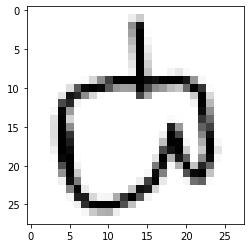

In [9]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Create discriminator network

In [0]:
def build_discriminator(depth=64, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [11]:
discriminator = build_discriminator()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

In [0]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Nadam(lr=0.0008, 
                                     clipvalue=1.0), 
                      metrics=['accuracy'])

#### Create generator network

In [0]:
z_dimensions = 32

In [0]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [0]:
generator = build_generator()

In [17]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

#### Create adversarial network

In [0]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [0]:
discriminator.trainable = False

In [0]:
pred = discriminator(img)

In [0]:
adversarial_model = Model(z, pred)

In [0]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=Nadam(lr=0.0004, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Train!

In [0]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # sample real images: 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # train discriminator: 
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

_N.B.: Running the next cell leads to the following warning in recent versions of TensorFlow:_

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

_This warning can be safely ignored. In most neural networks, you should indeed ensure that you compile the model after adjusting whether the models weights are trainable or not. In a GAN, however, this is unnecessary: The discriminator need not be compiled after making its weights untrainable; instead, we compile these untrainable weights as a part of the adversarial model. You can read more about this unnecessary warning [here](https://github.com/keras-team/keras/issues/8585) and [here](https://github.com/tensorflow/tensorflow/issues/22012). If the warning **really** bothers you though, we created a GAN notebook with an awkward workaround [here](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/awkward-GAN-with-no-warning.ipynb)._

Epoch #99
99: [D loss: 0.318616, acc: 0.974511]  [A loss: 4.121628, acc: 0.121291]


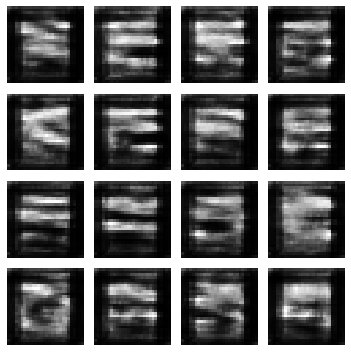

Epoch #199
199: [D loss: 0.236778, acc: 0.963980]  [A loss: 4.355791, acc: 0.074709]


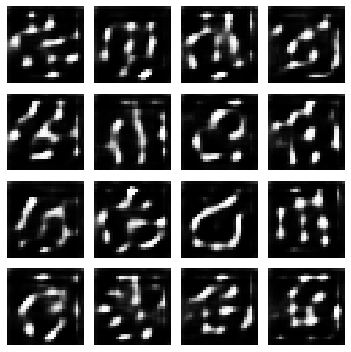

Epoch #299
299: [D loss: 0.247460, acc: 0.941158]  [A loss: 3.895463, acc: 0.068170]


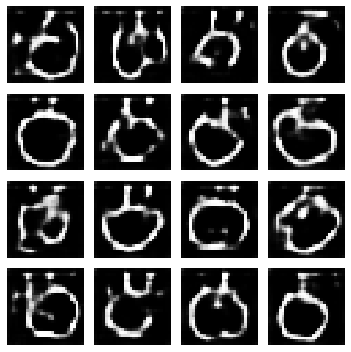

Epoch #399
399: [D loss: 0.283007, acc: 0.912702]  [A loss: 3.500734, acc: 0.077087]


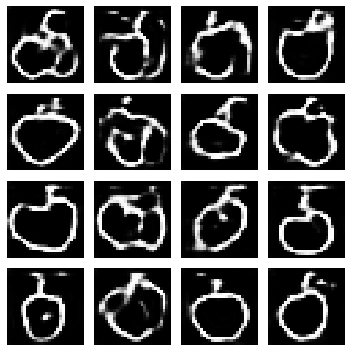

Epoch #499
499: [D loss: 0.322091, acc: 0.885349]  [A loss: 3.144754, acc: 0.092905]


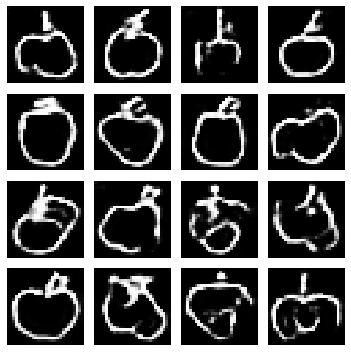

Epoch #599
599: [D loss: 0.349776, acc: 0.865570]  [A loss: 2.890695, acc: 0.105775]


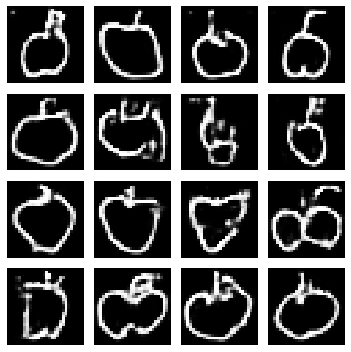

Epoch #699
699: [D loss: 0.368507, acc: 0.851646]  [A loss: 2.716047, acc: 0.114639]


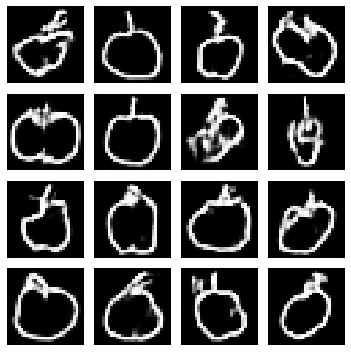

Epoch #799
799: [D loss: 0.382409, acc: 0.841071]  [A loss: 2.588572, acc: 0.122028]


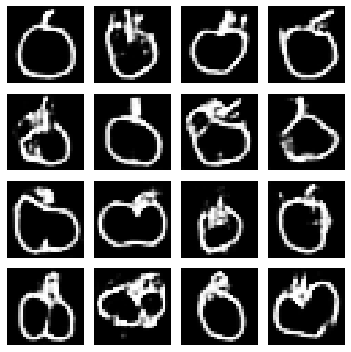

Epoch #899
899: [D loss: 0.393224, acc: 0.832879]  [A loss: 2.481055, acc: 0.128971]


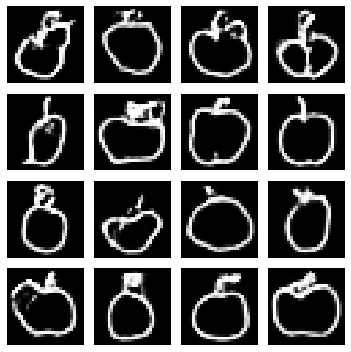

Epoch #999
999: [D loss: 0.401299, acc: 0.826455]  [A loss: 2.403311, acc: 0.133196]


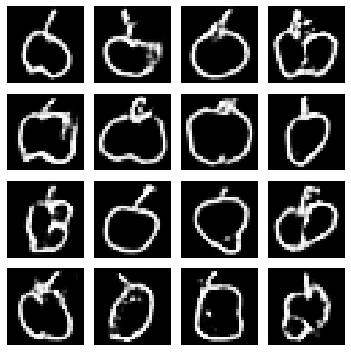

Epoch #1099
1099: [D loss: 0.407502, acc: 0.821724]  [A loss: 2.341850, acc: 0.136331]


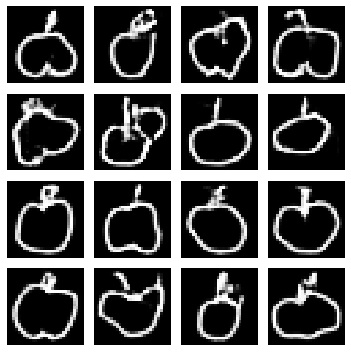

Epoch #1199
1199: [D loss: 0.412217, acc: 0.818299]  [A loss: 2.291361, acc: 0.138690]


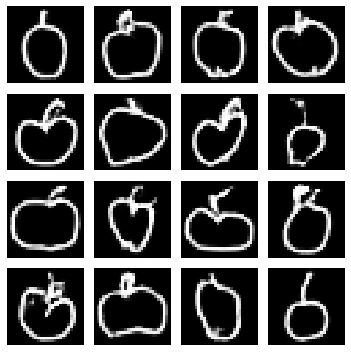

Epoch #1299
1299: [D loss: 0.415385, acc: 0.815865]  [A loss: 2.254357, acc: 0.140661]


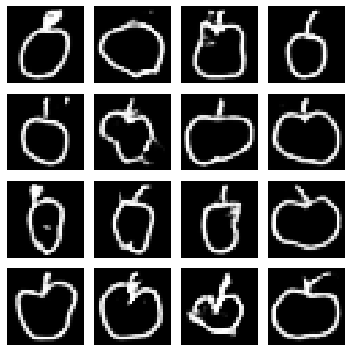

Epoch #1399
1399: [D loss: 0.417739, acc: 0.813734]  [A loss: 2.227611, acc: 0.141256]


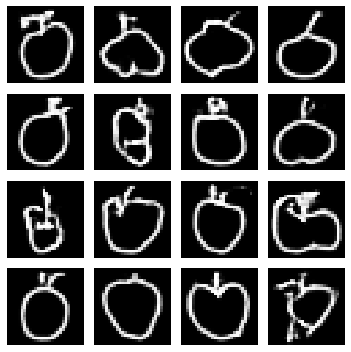

Epoch #1499
1499: [D loss: 0.418639, acc: 0.812810]  [A loss: 2.207931, acc: 0.141845]


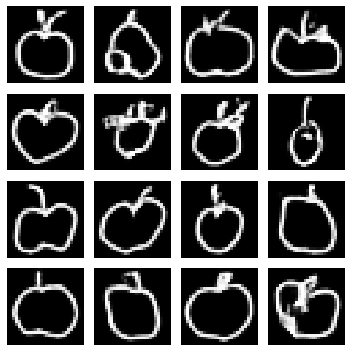

Epoch #1599
1599: [D loss: 0.419322, acc: 0.812024]  [A loss: 2.190374, acc: 0.142687]


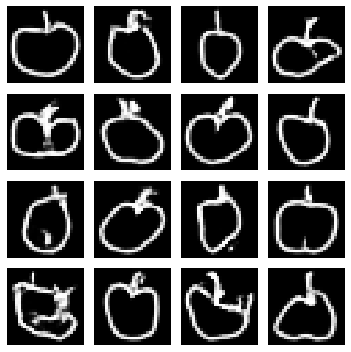

Epoch #1699
1699: [D loss: 0.419211, acc: 0.811753]  [A loss: 2.180000, acc: 0.142680]


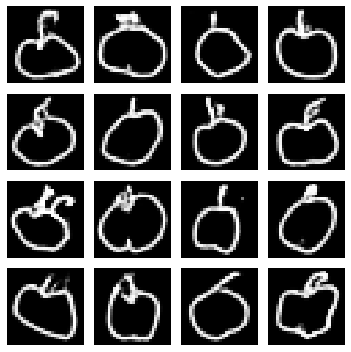

Epoch #1799
1799: [D loss: 0.419421, acc: 0.811336]  [A loss: 2.171294, acc: 0.142961]


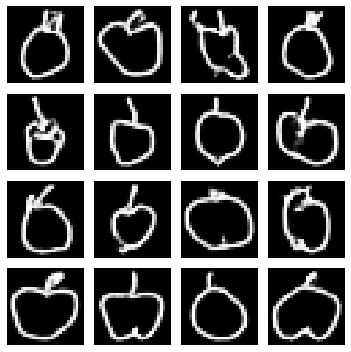

Epoch #1899
1899: [D loss: 0.419241, acc: 0.811048]  [A loss: 2.165183, acc: 0.142567]


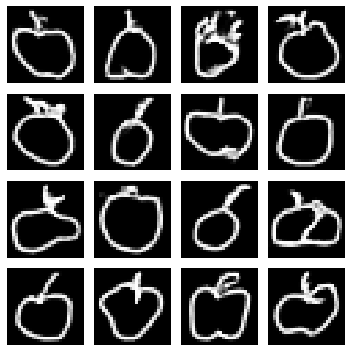

Epoch #1999
1999: [D loss: 0.418722, acc: 0.811105]  [A loss: 2.162979, acc: 0.142259]


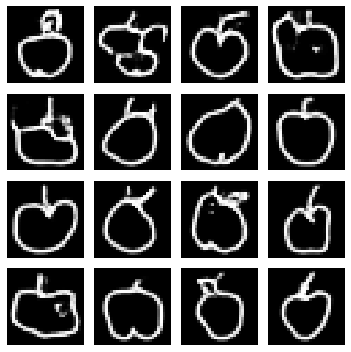

In [24]:
a_metrics_complete, d_metrics_complete = train()

Text(0, 0.5, 'Loss')

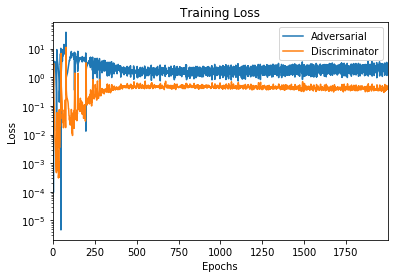

In [25]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

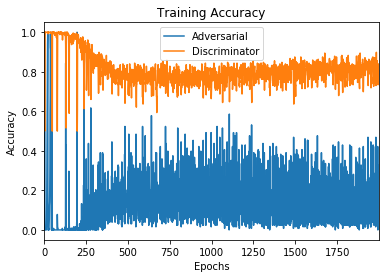

In [26]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")